In [1]:
from mitarspysigproc import (
    pfb_decompose,
    pfb_reconstruct,
    kaiser_coeffs,
    kaiser_syn_coeffs,
    npr_analysis,
    npr_synthesis,
    rref_coef,
)
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import scipy.constants as sconst
import xarray as xr

from SimISR import MakePulseDataRepLPC
from SimISR.testfunctions import temp_profile, chapman_func

In [2]:
nchans = 64
nslice = 2048
fs = 10000
t_len = nchans*nslice/fs
bw = 2000
ntaps = 64
g_del = nchans*(ntaps-1)//2
nzeros = 2048
coeffs = rref_coef(nchans, ntaps)
print(coeffs.shape)

(32, 64)


In [3]:
xpfb = np.zeros((nchans,4224),dtype=np.complex64)
xpfb[-1,64:-64] = 1
xpfb[0,64:-64] = 1
xpfb[2,64:-64] = 1
xpfb[13,64:-64] = 1
xpfb[12,64:-64] = 10

x_rec = npr_synthesis(xpfb, nchans, coeffs)


(-1000.0, 1000.0)

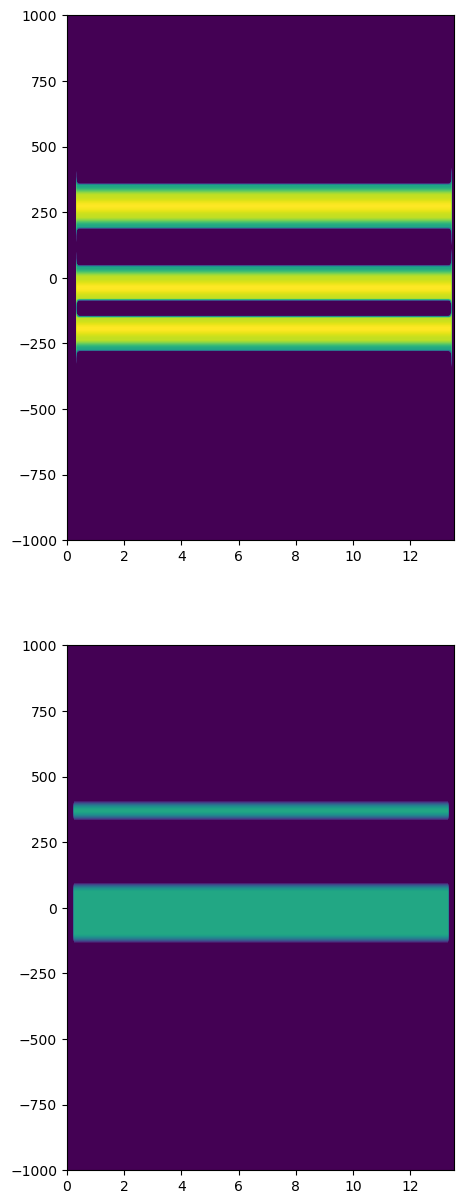

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(5, 15))
nfft = 256
w = sig.get_window("blackman", nfft)
SFT = sig.ShortTimeFFT(
    w, hop=nfft, fs=fs, mfft=nfft, scale_to="magnitude", fft_mode="centered"
)

sxout = 20 * np.log10(np.abs((SFT.stft(x_rec))) + 1e-12) 


im2 = ax[0].imshow(
    sxout[::-1],
    origin="lower",
    aspect="auto",
    extent=SFT.extent(len(x_rec)),
    cmap="viridis",
    vmin=-50,
    vmax=0,
)
ax[0].set_ylim([-1000,1000])

nchan, nslice = xpfb.shape
x_pfb = np.fft.fftshift(xpfb / np.abs(xpfb.flatten()).max(), axes=0)
x_pfb_db = 20 * np.log10(np.abs(x_pfb) + 1e-12)
im3 = ax[1].imshow(
    x_pfb_db,
    origin="lower",
    aspect="auto",
    extent=SFT.extent(len(x_rec)),
    cmap="viridis",
    vmin=-50,
    vmax=0,
)
ax[1].set_ylim([-1000,1000])

In [5]:
from ISRSpectrum import Specinit
species = ["O+", "e-"]
f_o = 440.2e6
f_vec = np.linspace(9.077e6,9.079e6,2**18)
spec_args = dict(centerFrequency=440.2e6,sampfreq=25e6,f=f_vec)
sp1 = Specinit(**spec_args)

8.978662820487434


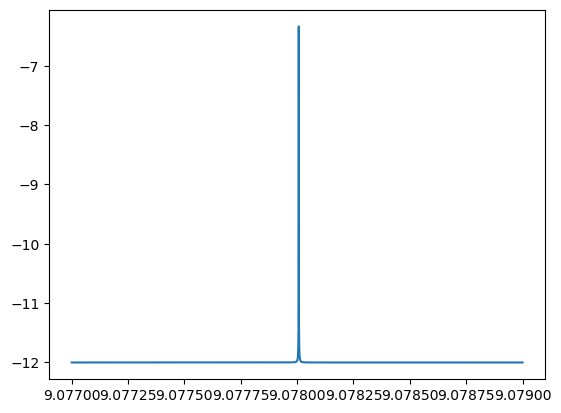

In [6]:
ne = 1e12
data_array = np.array([[ne,1500],[ne,4500]])
_,[ispec,espec], rcs = sp1.getspecsep(data_array,species,rcsflag=True,seplines=True)
Te = 4500
Ti = 2000
f_p = sconst.e*np.sqrt(ne/(sconst.epsilon_0*sconst.m_e))/2/sconst.pi
print(f_p*1e-6)

plt.plot(f_vec*1e-6,np.log10(espec+1e-12))



The resonance frequeny from Nicolls 2006 paper is

$f_r^2 = f_p^2 +\frac{3k^2}{4\pi^2}\frac{k_bT_e}{m_e} + f_c^2*\sin^2\alpha$

* $f_p^2= \frac{N_ee^2}{4\pi^2m_e\varepsilon_0}$ is the plasma frequency.
* $ k_b$ Boltzmann constant
* $e$ is the electron charge
* $\varepsilon_0$ is the permitivity of free space
* $k$ is the scattering wavenumber
* $f_c^2=\frac{eB}{4*\pi^2 m_ec}$ the gyro frequency
* $\alpha$ is the angle between the wave vector and the magnetic field. Akbari 2017 uses $\phi=90^o-\alpha$ makes everything $\cos$ terms instead
* $v_{th}^2 = k_bT_e/m_e$ Thermal velocity.

In [7]:
print(sp1.K)
fr = np.sqrt(f_p**2+(3*sp1.K**2*sconst.k*Te)/(4*sconst.pi**2*sconst.m_e))
kp = (2*sconst.pi/sconst.c)*(f_o+f_o+fr)
km = (2*sconst.pi/sconst.c)*(f_o+f_o-fr)
print(fr*1e-6)

frp = np.sqrt(f_p**2+(3*kp**2*sconst.k*Te)/(4*sconst.pi**2*sconst.m_e))
frm = np.sqrt(f_p**2+(3*km**2*sconst.k*Te)/(4*sconst.pi**2*sconst.m_e))

print("Upper freq {0} Lower Freq {1}".format(frp*1e-6,frm*1e-6))

18.451819573262604
9.076397294202737
Upper freq 9.07841172058413 Lower Freq 9.074403088524635


To get the up-shifted and downshifted lines you replace $k$ with the following

$k_{\pm} = \frac{2\pi}{c}[f_0 +(f_0+f_r)]$

where $f_0$ is the center frequency of the radar. The calcuation works out once you correct for the frequency difference at Aricibo vs MH (430 MHz instead of 440.2 MHz). According to the paper the multiplication infront of $T_e$ should be 0.869.

In [8]:
(430/440.2)*(frp-frm)/Te

0.870165977879971

This is from Nilsson et al 1996. 

$ A_{pl}= g^{\pm} e^2/\varepsilon_0 k^2$

* $A_{pl}$ power difference of the ion line and plasma line.
* $ g^{\pm}$ is the gain difference between the plasma line and ion line.
* $e$ is the electron charge
* $\varepsilon_0$ is the permitivity of free space
* $k$ is the scattering wavenumber

This leads to an amplitude difference of like 1e-29, so that doesn't make sense.

In [9]:
powdifo= sconst.e**2/(sconst.epsilon_0*sp1.K**2)
print("Power ratio {0}, {1} dB ".format(powdifo,10*np.log10(powdifo)))

Power ratio 8.515176591072928e-30, -290.69806341038634 dB 


Akbari 2017 uses $\frac{N_e\lambda_0^2e^2}{4\pi(1+Te/Ti)}$$k_s^2\lambda_D^2$ as the difference in power.

* $\lambda_D^2 = \frac{\varepsilon_0 k_b T_e}{e^2 N_e}$ Debye length
* $k_s$ is the scattering wavenumber

This seems to be more reasonable. 

It's probably easier to just use the following for volumetric rcs
$\sigma_v = N_e\frac{(k_s\lambda_d)^2T_{pe}}{2}$

* $\lambda_D^2 = \frac{\varepsilon_0 k_b T_e}{e^2 N_e}$ Debye length
* $k_s$ is the scattering wavenumber
* $T_{pe}$ the ratio of "plasma-line" temperature to electron temperature $T_p/T_e$

The plasma line ratio is likely easier to use so a bunch of different unit conversions can be avoided. 

In [13]:
lam0 = 4*np.pi/sp1.K
pow_dif2 = ne*lam0**2*sconst.e**2/((1+Te/Ti)*4*np.pi)/sconst.k

lambd2 = sconst.epsilon_0*sconst.k*Te/(ne*sconst.e**2)
pow_dif = sp1.K**2 * lambd2/2
print("Power ratio {0}, {1} dB ".format(pow_dif,10*np.log10(pow_dif)))

Power ratio 0.0036481454222061886, -24.3792785817177 dB 


## Lorentzian

Used a Lorentzian function with a $\gamma$ parameters as the half-width half maximum (HWHM) and $2\gamma$ is full width half maximum (FWHM). This case the FWHM is 20 kHz. According to Bill the fft size is 1024 ish on the plasma line channel so about  ~25 kHz bin size and that the plasma line takes up only one bin.

Text(0.5, 1.0, 'Lorentzian PSD with 20.0 kHz FWHM')

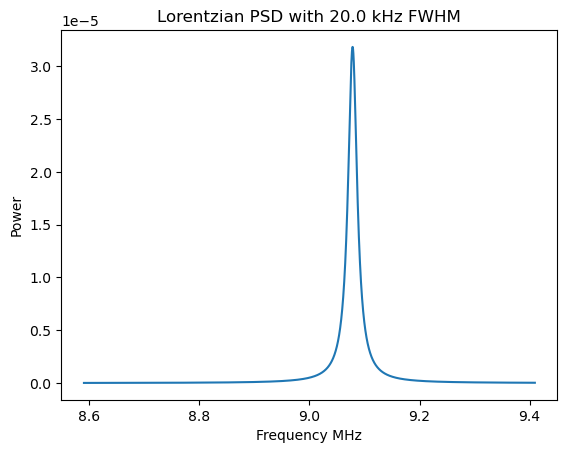

In [10]:
df = 100
f_up = np.arange(-4096,4096,dtype=float) *df + 9e6
gam = 10000
lore = 1/((1+(f_up-frp)**2/gam**2)*gam*np.pi)

plt.plot(f_up*1e-6,lore)
plt.xlabel('Frequency MHz')
plt.ylabel('Power')
plt.title('Lorentzian PSD with {0} kHz FWHM'.format(2*gam*1e-3))

Text(0.5, 1.0, 'Lorentzian shaped noise PSD with 20.0 kHz FWHM')

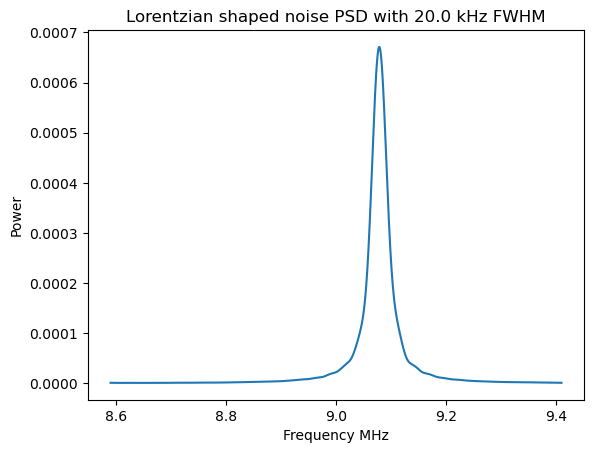

In [11]:
p1 = np.ones((1000,32))

d1 = MakePulseDataRepLPC(p1,lore,25,np.arange(1000),numtype=np.complex64)
dfft = np.fft.fft(d1,n=8192,axis=1)
dpsd = np.mean(np.abs(dfft)**2,axis=0)
dpsds = np.fft.fftshift(dpsd)

plt.plot(f_up*1e-6,dpsds)
plt.xlabel('Frequency MHz')
plt.ylabel('Power')
plt.title('Lorentzian shaped noise PSD with {0} kHz FWHM'.format(2*gam*1e-3))

Text(0, 0.5, 'Hight km')

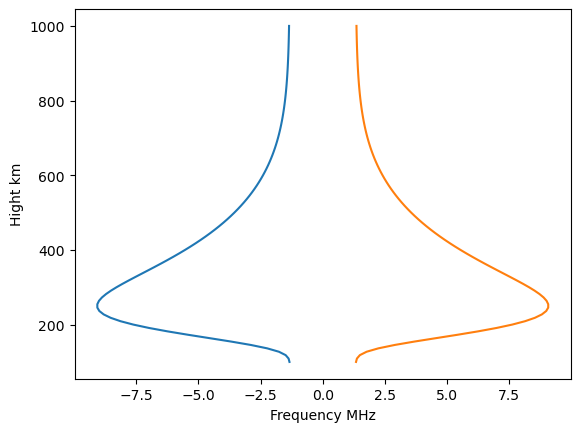

In [12]:

z = np.linspace(100,1000,100)
N_0=1e12
z_0=250.0
H_0=50.0
Ne_profile = chapman_func(z, H_0, z_0, N_0)
(Te_prof, Ti_prof) = temp_profile(z)

f_p = sconst.e*np.sqrt(Ne_profile/(sconst.epsilon_0*sconst.m_e))/2/sconst.pi

fr = np.sqrt(f_p**2+(3*sp1.K**2*sconst.k*Te_prof)/(4*sconst.pi**2*sconst.m_e))
kp = (2*sconst.pi/sconst.c)*(f_o+f_o+fr)
km = (2*sconst.pi/sconst.c)*(f_o+f_o-fr)

frp = np.sqrt(f_p**2+(3*kp**2*sconst.k*Te)/(4*sconst.pi**2*sconst.m_e))
frm = np.sqrt(f_p**2+(3*km**2*sconst.k*Te)/(4*sconst.pi**2*sconst.m_e))

plt.plot(-frm*1e-6,z,frp*1e-6,z)
plt.xlabel('Frequency MHz')
plt.ylabel('Hight km')

In [13]:
fs = 25000000
nchans = 250
c_bw = fs/nchans
rng_s = 1e-3*sconst.c/c_bw/2
rng_vec = np.arange(100,700.,rng_s)
plen = int(480e-6*c_bw)
print(rng_vec[:10])
print(rng_s)
print(c_bw)
print(plen)

N_prof = chapman_func(rng_vec, H_0, z_0, N_0)
(Te_prof, Ti_prof) = temp_profile(rng_vec)

f_p = sconst.e*np.sqrt(N_prof/(sconst.epsilon_0*sconst.m_e))/2/sconst.pi

fr = np.sqrt(f_p**2+(3*sp1.K**2*sconst.k*Te_prof)/(4*sconst.pi**2*sconst.m_e))
kp = (2*sconst.pi/sconst.c)*(f_o+f_o+fr)
km = (2*sconst.pi/sconst.c)*(f_o+f_o-fr)

frp = np.sqrt(f_p**2+(3*kp**2*sconst.k*Te)/(4*sconst.pi**2*sconst.m_e))
frm = -1*np.sqrt(f_p**2+(3*km**2*sconst.k*Te)/(4*sconst.pi**2*sconst.m_e))


[100.         101.49896229 102.99792458 104.49688687 105.99584916
 107.49481145 108.99377374 110.49273603 111.99169832 113.49066061]
1.49896229
100000.0
48


In [14]:
def spec_func(f,f_0,gam):
    lore = 1/((1+(f-f_0)**2/gam**2)*gam*np.pi)
    return lore

In [17]:
fs = 25000000

nchans = 250
c_bw = fs/nchans
n_fpfb = 1024
freq_vec = np.fft.fftshift(np.fft.fftfreq(nchans,1/fs))
freq_ind = np.arange(nchans)
bw2 = fs/nchans/2
freq_l = freq_vec-bw2
freq_h = freq_vec+bw2
cfreqvec = np.fft.fftshift(np.fft.fftfreq(n_fpfb,1/c_bw))
fwhm = 2*gam
skirt = fwhm*2
npulses=100

g_del = nchans*(ntaps-1)//2//2
g_delp = nchans*(ntaps-1)//2

n_rg_bins = len(rng_vec)+plen+g_delp//nchans
rng_s = 1e-3*sconst.c/c_bw/2

dout =  np.zeros((nchans,n_rg_bins,npulses),dtype=np.complex64)
dpulse = np.ones((npulses,plen))
pkeep = np.arange(npulses)
for irng,irngv in enumerate(rng_vec):
    #lower line
    f_0m = frm[irng]
    lb = freq_ind[f_0m-skirt>freq_l][-1]
    ub = freq_ind[f_0m+skirt<freq_h][0]
    cur_bin = freq_ind[lb:ub+1]
    # cur_bin = np.where(np.logical_and(ub,lb))[0]

    # if len(cur_bin)==0:
    #     ipdb.set_trace()
    for bin_i in cur_bin:
        cf_i = freq_vec[bin_i]
        spec_i = spec_func(cfreqvec+cf_i,f_0m,gam)
        data_i = MakePulseDataRepLPC(dpulse,spec_i,25,pkeep,numtype=np.complex64)
        dout[bin_i,irng:irng+plen,pkeep] += data_i

    # #upper line
    f_0p = frp[irng]
    lb = freq_ind[f_0p-skirt>freq_l][-1]
    ub = freq_ind[f_0p+skirt<freq_h][0]
    cur_bin = freq_ind[lb:ub+1]
    
    for bin_i in cur_bin:
        cf_i = freq_vec[bin_i]
        spec_i = spec_func(cfreqvec+cf_i,f_0p,gam)
        data_i = MakePulseDataRepLPC(dpulse,spec_i,25,pkeep,numtype=np.complex64)
        dout[bin_i,irng:irng+plen,pkeep] += data_i

coeffs = rref_coef(nchans, ntaps)
# have to flip the bins because the synthesis is expecting things to be in the wrong direction.
dout = np.fft.fftshift(dout[::-1],axes=0)
full_data = npr_synthesis(dout,nchans,coeffs)
full_data = np.roll(full_data,-g_del,axis=0)
syn_coeffs = kaiser_syn_coeffs(nchans, 8)
mask = np.ones(nchans, dtype=bool)
fillmethod = ""
fillparams = [0, 0]

full_data_pfb = pfb_reconstruct(
    dout, nchans, syn_coeffs, mask, fillmethod, fillparams=[], realout=False
)
full_data_pfb = np.roll(full_data_pfb,-g_delp,0)

In [18]:

nfft = 1024
w = sig.get_window("boxcar", nfft)

SFT = sig.ShortTimeFFT(
    w, hop=nfft//2, fs=fs, mfft=nfft, scale_to="magnitude", fft_mode="centered"
)

dfft = SFT.stft(full_data,axis=0)
sxx = np.mean(dfft.real**2+dfft.imag**2,axis=1)
dout_mag = np.mean(dout.real**2+dout.imag**2,axis=-1)

dfftpfb = SFT.stft(full_data_pfb,axis=0)
sxxpfb = np.mean(dfftpfb.real**2+dfftpfb.imag**2,axis=1)
ext = [(-fs/2) *1e-6,(fs*1e-6/2)*(nfft-1)/nfft,100,100+(n_rg_bins*rng_s)]

In [133]:
print(np.nanmax(sxx))
print(np.nanmin(sxx))

print(np.nanmax(dout_mag))
print(np.nanmin(dout_mag))
print(dout_mag.shape)
print(np.mean(np.abs(full_data)**2))
print(np.mean(np.abs(data_i)**2))

2.5417312626946158e-05
0.0
0.00015674664
0.0
(250, 8324)
2.0922676720694578e-05
8.634364463544858e-06


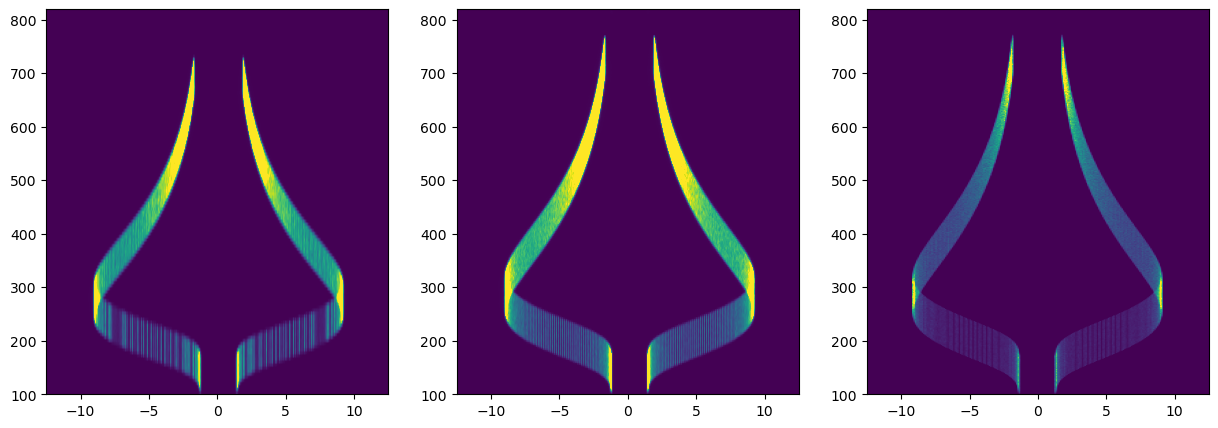

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

im2 = ax[0].imshow(
    sxx.T,
    origin="lower",
    aspect="auto",
    extent=ext,
    cmap="viridis",
    vmin=0,
    vmax=5e-6,
)
im2 = ax[1].imshow(
    sxxpfb.T,
    origin="lower",
    aspect="auto",
    extent=ext,
    cmap="viridis",
    vmin=0,
    vmax=5e-1,
)

im3 = ax[2].imshow(
    np.fft.fftshift(dout_mag.T,axes=1),
    origin="lower",
    aspect="auto",
    extent=ext,
    cmap="viridis",
    vmin=0,
    vmax=1e-4,
)
# ax[0].set_xlim([100,400])
# ax[0].set_ylim([10,30])

# ax[1].set_xlim([200,400])
# ax[1].set_ylim([50,150])

# ax[2].set_xlim([125,200])
# ax[2].set_ylim([50,150])

In [149]:
SFT.extent(len(full_data_pfb))
print(ext)

[-12.5, 12787.5, 100, 102.8780075968]
